In [12]:
import os
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['LOKY_MAX_CPU_COUNT'] = '6'
%matplotlib inline

In [13]:
offers_connection = sqlite3.connect('../datasets/offers_dataset.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()

with sqlite3.connect('../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)

In [14]:
offers_frame.dropna(subset='Name',inplace=True)
offers_frame.drop_duplicates(inplace=True)
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
587,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia"
588,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio"
589,R&D Labeling Principal Engineer,This is where you save and sustain lives \n ...,"Medolla, Emilia-Romagna"
590,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia"


La sezione seguente riguardo l'estrazione delle skill verrà rimossa quando offers_preparation sarà completo (con export dataset preparato)

In [15]:
# this import will be removed when the loaded dataset will be already complete
from commons import (
    remove_symbols, 
    extract_symbols, 
    translate_skills, 
    id_to_skill, 
    REMOVAL
)

In [16]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]
required_skills = [] 

# Extract skills from descriptions and add new column
for i, offer_description in enumerate(offers_frame.loc[:, 'Description']):
    desc = remove_symbols(offer_description, REMOVAL)
    offer_skills = extract_symbols(desc, skills_list)
    required_skills.append(translate_skills(offer_skills, skills_frame, to_id=True))  
    #required_skills.append(offer_skills)
offers_frame.insert(len(offers_frame.columns), "RequiredSkills", required_skills)

# Remove offers with no required skills
offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(lambda x: np.NaN if not x else x)
offers_frame.dropna(subset='RequiredSkills', inplace=True)
offers_frame.reset_index(drop=True, inplace=True)

## Distance Matrix 

In [17]:
from commons import (
    get_distance_matrix,
    kmeans_silhouette
)

distance_matrix = get_distance_matrix(offers_frame, 'RequiredSkills')
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,481
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
1,1.0,0.000000,0.888889,0.400000,0.846154,0.833333,0.600000,1.000000,1.000000,0.833333,...,1.000000,0.888889,0.777778,0.933333,0.833333,1.0,0.875000,0.857143,1.0,1.0
2,1.0,0.888889,0.000000,1.000000,0.636364,0.833333,0.833333,1.000000,0.857143,0.833333,...,0.833333,0.888889,1.000000,0.857143,1.000000,1.0,1.000000,0.857143,1.0,1.0
3,1.0,0.400000,1.000000,0.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,...,1.000000,0.857143,0.714286,0.923077,0.750000,1.0,0.833333,1.000000,1.0,1.0
4,1.0,0.846154,0.636364,1.000000,0.000000,0.800000,0.909091,1.000000,0.700000,0.909091,...,0.800000,0.846154,1.000000,0.687500,1.000000,1.0,1.000000,0.916667,1.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.0
478,1.0,0.875000,1.000000,0.833333,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,...,1.000000,0.875000,0.750000,0.846154,0.500000,1.0,0.000000,0.833333,1.0,1.0
479,1.0,0.857143,0.857143,1.000000,0.916667,0.750000,0.750000,1.000000,1.000000,0.750000,...,1.000000,1.000000,0.714286,0.923077,0.750000,1.0,0.833333,0.000000,1.0,1.0
480,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.0


## Clustering 

### Silhouette Score

Per valutare il clustering effettuato useremo il Silhouette Score invece dell'Elbow Point dato che è che il punto di gomito è meno efficace, di solito, con dati complessi, inoltre il Silhouette Score fornisce più dettagli riguardo alle relazioni, in particolare alla separazione, tra cluster.

Per interpretare i risultati del Silhouette Score è importante notare che i valori, che variano da -1 a +1 hanno i seguenti significati:
-  1: Gli Item sono assegnati a un cluster specifico e i cluster sono facilmente distinguibili.
-  0: I cluster si sovrappongono.
- -1: Gli Item vengono assegnati a cluster errati.

L'algoritmo di clustering proposto è il KMeans, questo perchè ...
Per scegliere il valore di *k* abbiamo deciso di provare a calcolare il punteggio di Silhouette per diversi valori di *k* e scegliere quello con il risultato migliore.

In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import KMeans
import time

def evaluate_clustering(k):
    tmp_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42)
    tmp_labels = tmp_kmeans.fit_predict(distance_matrix)
    offers_frame['Group'] = tmp_labels
    
    silhouette_score = kmeans_silhouette(offers_frame, tmp_kmeans)
    return silhouette_score, k

# --- See how many clusters perform the best
max_value = -2
best_value = 0
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(evaluate_clustering, k) for k in range(3, 7)]
    for future in as_completed(futures):
        try:
            value, k = future.result()
            print(f'Score for {k}: {value:.3f}')
            if value > max_value:
                best_value = k
        except Exception as something:
            import traceback
            traceback.print_exc()
            print(f'Something went wrong: {something}')
            break

Score for 3: -0.008
Score for 4: -0.001
Score for 5: -0.005
Score for 6: 0.011


In [19]:
# --- best
# k-means++ is best for high-dimensional data
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
labels = kmeans.fit_predict(distance_matrix)
offers_frame['Group'] = labels

### Visualizzazione dei Cluster

Visualizzare i risultati è importante per poter trarre delle conclusioni sulla qualità del clustering, la natura dei dati che bisogna visualizzare è però multidimensionale, questo può rendere arduo effettuare un plot; analizzando il problema possiamo dire che il nostro obbiettivo è *poter associare delle coordinate (x, y) a ogni Offerta nel dataset*, in particolare sfruttando la matrice delle distanze.
Per fare ciò useremo la riduzione delle dimensionalità tramite **Principal Component Analysis**. 

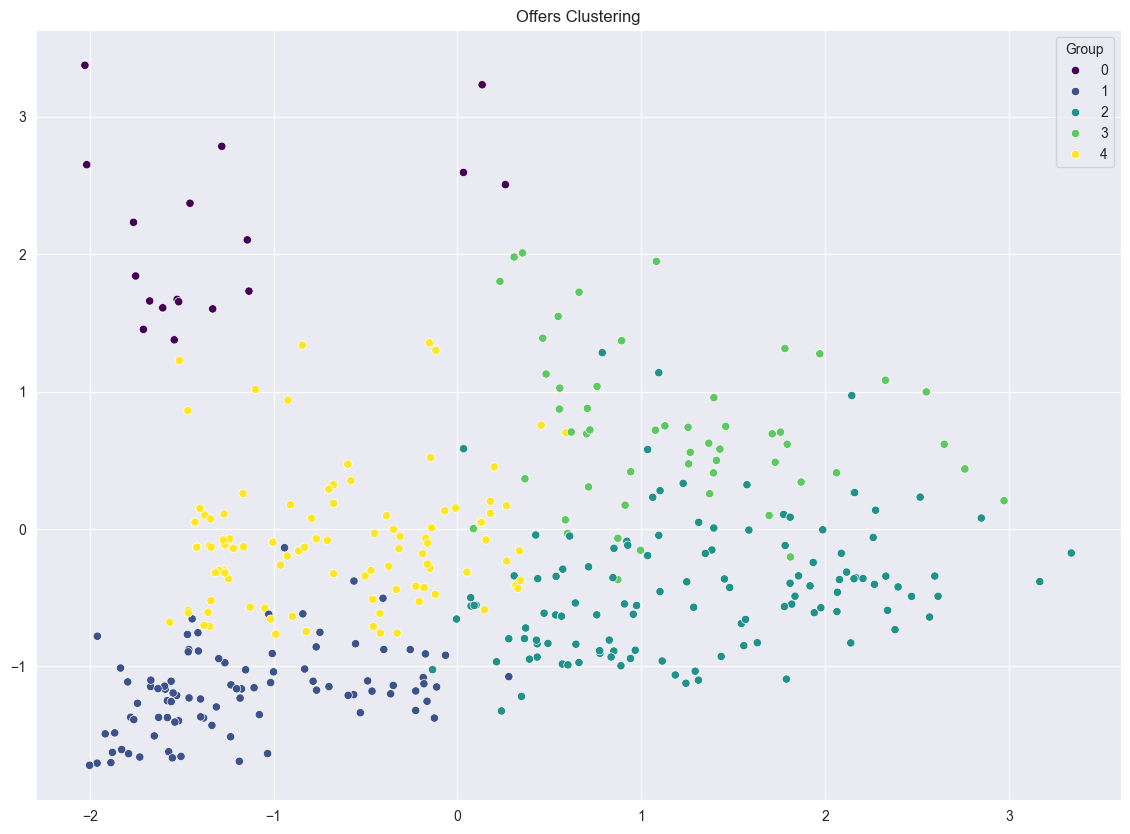

In [23]:
from sklearn.decomposition import PCA
from matplotlib.patches import Circle


pca = PCA(2)
group_labels = offers_frame['Group']
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=group_labels, palette='viridis')
plt.title('Offers Clustering')
"""
groups = group_labels.unique()
for group in groups:
    group_data = reduced_data[labels == group]
    mean_x = group_data[:, 0].mean()
    mean_y = group_data[:, 1].mean()
    circle = Circle((mean_x, mean_y), 0.6, fill=False, linewidth=3, edgecolor='red', )
    plt.gca().add_artist(circle)
    plt.text(mean_x, mean_y, str(group), ha='center', va='center', fontsize=18, color='black')
"""
plt.show()

Dopo aver analizzato lo scatterplot si è concluso che 6 cluster non erano buoni, in quanto due erano *"accavallati"*, quindi nonostante il punteggio di Silhouette fosse più alto si è optato per un **k = 5**, ottenendo così risultati migliori. 
***Nota**: abbiamo usato dei cerchi per evidenziare i gruppi, ma non sono rappresentativi della forma dei cluster, inoltre hanno una dimensione scelta in modo casuale*

### TESTS









...

**Esempi**

In [21]:
def _similar_offers_with_cluster(offer_id: int) -> list:
    target_group = offers_frame.loc[offer_id, 'Group']
    return list(
        offers_frame[
            offers_frame['Group'] == target_group
        ].index
    )

def similar_offers_with_cluster(offer_id: int) -> list:
    return [offers_frame.iloc[oid] for oid in _similar_offers_with_cluster(offer_id)]
offers_frame

,Name,Description,Location,RequiredSkills,Group
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",4
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",0
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 3, 6, 44, 26}",1
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",0
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 3, 99, 6, 7, 104, 55, 57, 26}",1
...,...,...,...,...,...
477,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},4
478,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{89, 73, 2, 30}",2
479,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{31, 30, 6}",2
480,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},4


In [22]:
# Frontend: {css, javascript, html}
print(f'Offers Similar to {offers_frame.iloc[8]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(8)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Frontend:


TypeError: id_to_skill() missing 1 required positional argument: 'skills_frame'

In [ ]:
# Machine Learning Ops/Engineer
print(f'Offers Similar to {offers_frame.iloc[240]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(240)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

In [ ]:
# Machine Learning / Java Developer
print(f'Offers Similar to {offers_frame.iloc[237]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(237)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')